## Importing Libraries && Loading the Dataset

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import pickle
import os
import numpy as np

In [25]:
df_old = pd.read_csv('Data/Data.csv')
df_old

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Dataset had too Little Correlation with the EstimatedSalary Column so We are Transforming the Column to have a High Corrrelation with the Rest of the Features 

In [26]:
# Recreate the modified file (since it doesn't exist in current session)
data_path = "Data/Data.csv"
salaries_path = "Data/Salaries.csv"

data_df = pd.read_csv(data_path)
salaries_df = pd.read_csv(salaries_path)

# Clean Salaries.csv
salaries_df = salaries_df.drop(columns=['Id', 'EmployeeName', 'Notes', 'Agency', 'Status', 'Year'])
salaries_df['BasePay'] = pd.to_numeric(salaries_df['BasePay'], errors='coerce')
salaries_df['OvertimePay'] = pd.to_numeric(salaries_df['OvertimePay'], errors='coerce')
salaries_df['OtherPay'] = pd.to_numeric(salaries_df['OtherPay'], errors='coerce')
salaries_df['Benefits'] = pd.to_numeric(salaries_df['Benefits'], errors='coerce')
salaries_df = salaries_df[salaries_df['TotalPayBenefits'] > 0]

# Clean Data.csv
data_df = data_df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'EstimatedSalary'])

# Assign occupations randomly
np.random.seed(42)
data_df['Occupation'] = np.random.choice(salaries_df['JobTitle'].unique(), size=len(data_df))

# Merge mean salary
job_salaries = salaries_df.groupby('JobTitle')['TotalPayBenefits'].mean().reset_index()
job_salaries.rename(columns={'JobTitle': 'Occupation', 'TotalPayBenefits': 'MeanSalary'}, inplace=True)
data_df = data_df.merge(job_salaries, on='Occupation', how='left')

# Feature engineering
data_df['Age_Tenure_Score'] = (data_df['Age'] * data_df['Tenure'])
data_df['Age_Tenure_Score'] = (data_df['Age_Tenure_Score'] - data_df['Age_Tenure_Score'].min()) / (data_df['Age_Tenure_Score'].max() - data_df['Age_Tenure_Score'].min())
data_df['Credit_Score_Norm'] = (data_df['CreditScore'] - data_df['CreditScore'].min()) / (data_df['CreditScore'].max() - data_df['CreditScore'].min())
data_df['Balance_Norm'] = (data_df['Balance'] - data_df['Balance'].min()) / (data_df['Balance'].max() - data_df['Balance'].min())

# Realistic salary calculation
data_df['RealisticSalary'] = (data_df['Age_Tenure_Score'] * 0.4 +
                              data_df['Credit_Score_Norm'] * 0.3 +
                              data_df['Balance_Norm'] * 0.3) * 200000 + 50000

# Drop helper columns but keep Occupation
data_df = data_df.drop(columns=['Age_Tenure_Score', 'Credit_Score_Norm', 'Balance_Norm', 'MeanSalary'])

# Save to CSV
output_path = "Data/Modified_Data.csv"
data_df.to_csv(output_path, index=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_268\2897554998.py:6: DtypeWarning: Columns (3,4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  salaries_df = pd.read_csv(salaries_path)


## Loading Transformed Dataset

In [27]:
df = pd.read_csv('Data/Modified_Data.csv')
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Occupation,RealisticSalary
0,619,France,Female,42,2,0.00,1,1,1,1,SENIOR CLERK TYPIST,89916.363636
1,608,Spain,Female,41,1,83807.86,1,0,1,0,Assistant Law Librarian,104729.161448
2,502,France,Female,42,8,159660.80,3,1,0,1,Dept Head II,136966.885102
3,699,France,Female,39,1,0.00,2,0,0,0,Chief Atty1 (Civil & Criminal),95425.454545
4,850,Spain,Female,43,2,125510.82,1,1,1,0,Dental Hygienist,147832.954748
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,0,IS Administrator 1,118247.272727
9996,516,France,Male,35,10,57369.61,1,1,1,0,"SENIOR INVESTIGATOR, OFFICE OF CITIZEN'S COMPL...",115457.603118
9997,709,France,Female,36,7,0.00,1,0,1,1,DIETETIC TECHNICIAN,115989.090909
9998,772,Germany,Male,42,3,75075.31,2,1,0,1,TRANSMISSION LINE SUPERVISOR I,130048.124137


## Preprocessing && Feature Engineering

In [28]:
geo_one = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
geo_vals = geo_one.fit_transform(df[['Geography']])
geo_df = pd.DataFrame(geo_vals,columns=geo_one.get_feature_names_out(['Geography']))
df = pd.concat([df,geo_df],axis=1)
gen_le = LabelEncoder()
df['Gender'] = gen_le.fit_transform(df[['Gender']])
df = df.drop(['Occupation','Geography'],axis=1)

d:\Client_Projects\Sir_Malik\ANN_Project\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
geo_df

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
9995,1.0,0.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,0.0,1.0,0.0


In [30]:
df

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,RealisticSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,1,89916.363636,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,0,104729.161448,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,1,136966.885102,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,0,95425.454545,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,0,147832.954748,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,0,118247.272727,1.0,0.0,0.0
9996,516,1,35,10,57369.61,1,1,1,0,115457.603118,1.0,0.0,0.0
9997,709,0,36,7,0.00,1,0,1,1,115989.090909,1.0,0.0,0.0
9998,772,1,42,3,75075.31,2,1,0,1,130048.124137,0.0,1.0,0.0


## Correlation Heat Map of Original Dataset

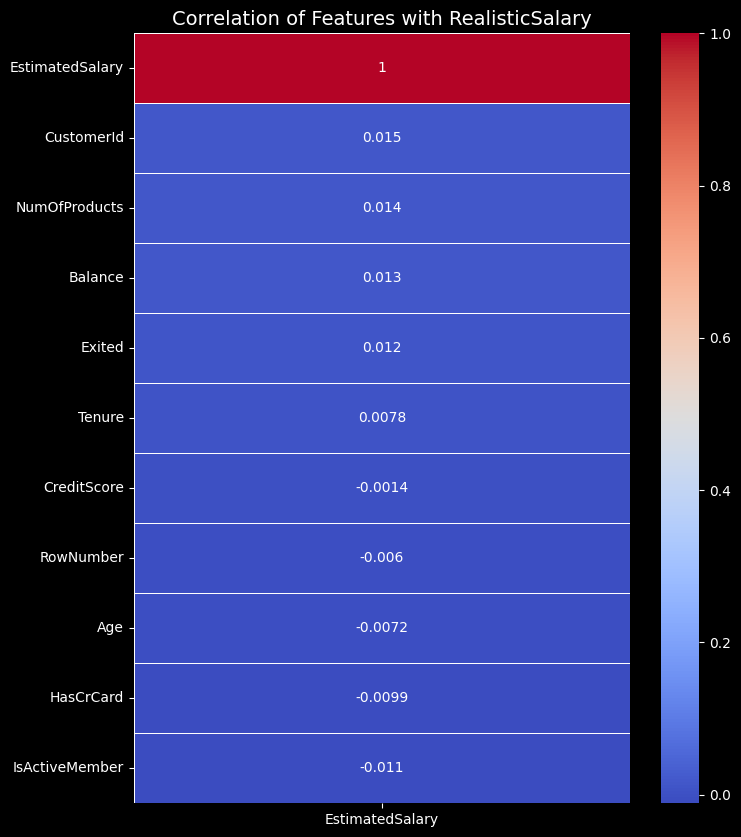

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df_old.select_dtypes(include=['number'])
corr = numeric_df.corr()["EstimatedSalary"].sort_values(ascending=False)

# Heatmap
plt.figure(figsize=(8,10))
sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation of Features with RealisticSalary", fontsize=14)
plt.show()


## Correlation Heat Map of Transformed Dataset

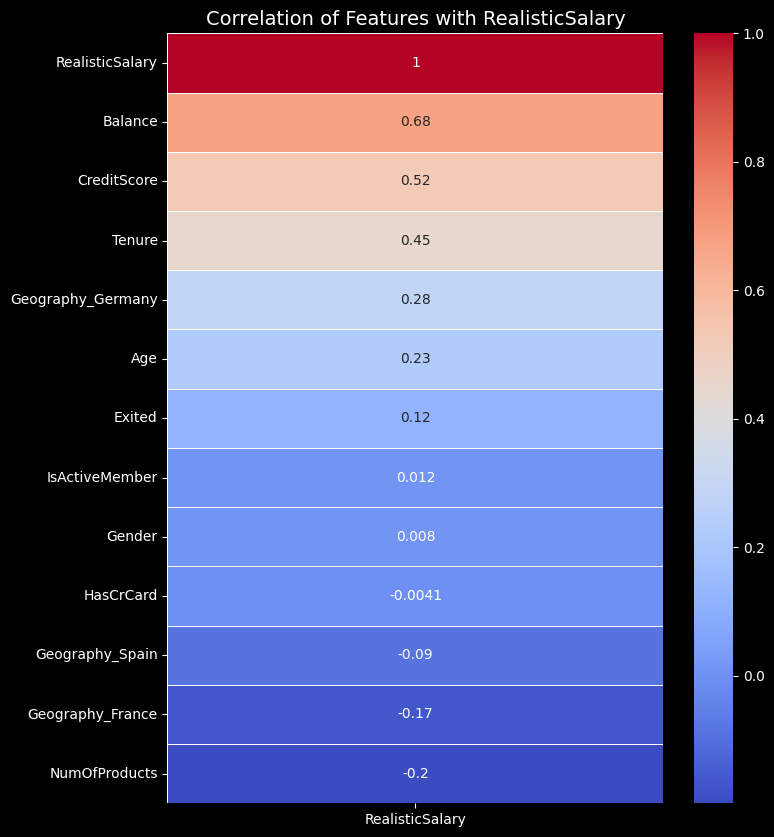

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()["RealisticSalary"].sort_values(ascending=False)

# Heatmap
plt.figure(figsize=(8,10))
sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation of Features with RealisticSalary", fontsize=14)
plt.show()


In [34]:
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['RealisticSalary'],axis=1))
y = df.RealisticSalary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
os.makedirs('pipelines',exist_ok=True)
with open('pipelines/labelencoder.pkl','wb') as f:
    pickle.dump(gen_le,f)
with open('pipelines/onehotencoder.pkl','wb') as f:
    pickle.dump(geo_one,f)
with open('pipelines/scaler.pkl','wb') as f:
    pickle.dump(scaler,f)


## ANN Implementation

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, models


def build_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")  
    ])
    return model


model = build_model(X_train.shape[1])


model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="mae",             
    metrics=["mae",'mse']          
)


early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    "models/best_model.keras", monitor="val_loss", save_best_only=True, verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/100


d:\Client_Projects\Sir_Malik\ANN_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


192/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121838.6953 - mae: 121838.6953 - mse: 15337915392.0000
Epoch 1: val_loss improved from None to 117317.79688, saving model to models/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 121148.2969 - mae: 121148.2969 - mse: 15172453376.0000 - val_loss: 117317.7969 - val_mae: 117317.7969 - val_mse: 14263457792.0000
Epoch 2/100
190/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 104580.1250 - mae: 104580.1250 - mse: 11733974016.0000
Epoch 2: val_loss improved from 117317.79688 to 24655.43164, saving model to models/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 81287.3750 - mae: 81287.3750 - mse: 8044555776.0000 - val_loss: 24655.4316 - val_mae: 24655.4316 - val_mse: 872792000.0000
Epoch 3/100
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19152.7383 - mae: 19152.7383 - mse: 577675136.0000
Epoch 3: val_loss improved from 24655.43164 to 6877.23926, saving model to models/best_model.keras
200/200 ━━━━━━━━━━━━━━━

## Deriving R2 Score of the Model -- 98%

In [39]:
from sklearn.metrics import r2_score

score = r2_score(y_test,model.predict(X_test))
score

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.9816692354592985